#Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Data Understanding

In [2]:
!curl -L -o onlineritel.zip\
  https://www.kaggle.com/api/v1/datasets/download/yasserh/customer-segmentation-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 21.8M  100 21.8M    0     0  13.1M      0  0:00:01  0:00:01 --:--:-- 13.1M


In [3]:
!unzip -q /content/onlineritel.zip

In [4]:
df = pd.read_excel('Online Retail.xlsx')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


### Cek jumlah transaksi, jumlah pelanggan unik

In [7]:
num_transactions = df.shape[0]
num_unique_customers = df['CustomerID'].nunique()

print(f"Number of transactions: {num_transactions}")
print(f"Number of unique customers: {num_unique_customers}")

Number of transactions: 541909
Number of unique customers: 4372


### Cek nilai hilang

In [8]:
print("Missing values:")
display(df.isnull().sum())

Missing values:


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


### nilai anomali (misal harga negatif, quantities negatif)

In [9]:
negative_quantity = df[df['Quantity'] < 0]
negative_price = df[df['UnitPrice'] < 0]

print(f"Number of transactions with negative quantity: {len(negative_quantity)}")
print(f"Number of transactions with negative UnitPrice: {len(negative_price)}")

if not negative_quantity.empty:
    print("\nExamples of transactions with negative quantity:")
    display(negative_quantity.head())

if not negative_price.empty:
    print("\nExamples of transactions with negative UnitPrice:")
    display(negative_price.head())

Number of transactions with negative quantity: 10624
Number of transactions with negative UnitPrice: 2

Examples of transactions with negative quantity:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom



Examples of transactions with negative UnitPrice:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


### Cek rentang tanggal transaksi

In [10]:
min_date = df['InvoiceDate'].min()
max_date = df['InvoiceDate'].max()

print(f"Transaction date range: {min_date} to {max_date}")

Transaction date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


#Data Cleaning

###Hapus canceled order (Quantity < 0)

In [11]:
df = df[df['Quantity'] > 0]
print(f"New shape after removing negative quantities: {df.shape}")
display(df.head())

New shape after removing negative quantities: (531285, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


###Hapus baris tanpa CustomerID

In [12]:
df.dropna(subset=['CustomerID'], inplace=True)
print(f"New shape after removing rows with missing CustomerID: {df.shape}")
display(df.head())

New shape after removing rows with missing CustomerID: (397924, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


###Hapus harga negatif

In [13]:
df = df[df['UnitPrice'] >= 0]
print(f"New shape after removing negative UnitPrice: {df.shape}")
display(df.head())

New shape after removing negative UnitPrice: (397924, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


###Tangani missing value

In [14]:
df.dropna(subset=['Description'], inplace=True)
print(f"New shape after removing rows with missing Description: {df.shape}")
display(df.head())

New shape after removing rows with missing Description: (397924, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


###Hapus transaksi non-retail (misal kode item aneh)

In [15]:
non_retail_stock_codes = [
    'POST', 'D', 'M', 'CRUK', 'BANK CHARGES', 'AMAZONFEE', 'S', 'DOT',
    'ADJUST', 'BOUNCE', 'TEST', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B'
]
df = df[~df['StockCode'].isin(non_retail_stock_codes)]
print(f"New shape after removing non-retail transactions: {df.shape}")
display(df.head())

New shape after removing non-retail transactions: (396503, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#Feature Engineering: Hitung RFM

###Menghitung Total Price


In [16]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print(f"New shape after adding TotalPrice column: {df.shape}")
display(df.head())

New shape after adding TotalPrice column: (396503, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


###Referensikan Tanggal


In [17]:
import datetime as dt

latest_date = df['InvoiceDate'].max()
reference_date = latest_date + dt.timedelta(days=1)

print(f"Latest InvoiceDate: {latest_date}")
print(f"Reference Date for RFM: {reference_date}")

Latest InvoiceDate: 2011-12-09 12:50:00
Reference Date for RFM: 2011-12-10 12:50:00


###Menghitung Recency


In [18]:
last_purchase_date = df.groupby('CustomerID')['InvoiceDate'].max()
recency = (reference_date - last_purchase_date).dt.days

rfm_df = pd.DataFrame(recency).reset_index()
rfm_df.columns = ['CustomerID', 'Recency']

print("Recency calculated:")
display(rfm_df.head())
print(rfm_df.describe())

Recency calculated:


,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310


         CustomerID      Recency
count   4335.000000  4335.000000
mean   15298.780392    92.684890
std     1722.075082   100.172622
min    12346.000000     1.000000
25%    13811.500000    18.000000
50%    15297.000000    51.000000
75%    16778.500000   143.000000
max    18287.000000   374.000000


###Menghitung Frequency

In [19]:
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
frequency = pd.DataFrame(frequency).reset_index()
frequency.columns = ['CustomerID', 'Frequency']

rfm_df = pd.merge(rfm_df, frequency, on='CustomerID')

In [20]:
print("Frequency calculated:")
display(rfm_df.head())
print(rfm_df.describe())

Frequency calculated:


,CustomerID,Recency,Frequency
0,12346.0,326,1
1,12347.0,2,7
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


         CustomerID      Recency    Frequency
count   4335.000000  4335.000000  4335.000000
mean   15298.780392    92.684890     4.246367
std     1722.075082   100.172622     7.643880
min    12346.000000     1.000000     1.000000
25%    13811.500000    18.000000     1.000000
50%    15297.000000    51.000000     2.000000
75%    16778.500000   143.000000     5.000000
max    18287.000000   374.000000   206.000000


###Menghitung Monetary

In [21]:
monetary = df.groupby('CustomerID')['TotalPrice'].sum()
monetary = pd.DataFrame(monetary).reset_index()
monetary.columns = ['CustomerID', 'Monetary']

rfm_df = pd.merge(rfm_df, monetary, on='CustomerID')

In [22]:
print("Monetary calculated:")
display(rfm_df.head())
print(rfm_df.describe())

Monetary calculated:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


         CustomerID      Recency    Frequency       Monetary
count   4335.000000  4335.000000  4335.000000    4335.000000
mean   15298.780392    92.684890     4.246367    2022.549631
std     1722.075082   100.172622     7.643880    8923.221446
min    12346.000000     1.000000     1.000000       0.000000
25%    13811.500000    18.000000     1.000000     305.765000
50%    15297.000000    51.000000     2.000000     668.110000
75%    16778.500000   143.000000     5.000000    1631.475000
max    18287.000000   374.000000   206.000000  279138.020000


#Understanding RFM

###Statistik RFM

In [23]:
print("RFM Statistics:")
display(rfm_df.describe())

RFM Statistics:


,CustomerID,Recency,Frequency,Monetary
count,4335.000000,4335.000000,4335.000000,4335.000000
mean,15298.780392,92.684890,4.246367,2022.549631
std,1722.075082,100.172622,7.643880,8923.221446
min,12346.000000,1.000000,1.000000,0.000000
25%,13811.500000,18.000000,1.000000,305.765000
50%,15297.000000,51.000000,2.000000,668.110000
75%,16778.500000,143.000000,5.000000,1631.475000
max,18287.000000,374.000000,206.000000,279138.020000


###Korelasi antar fitur

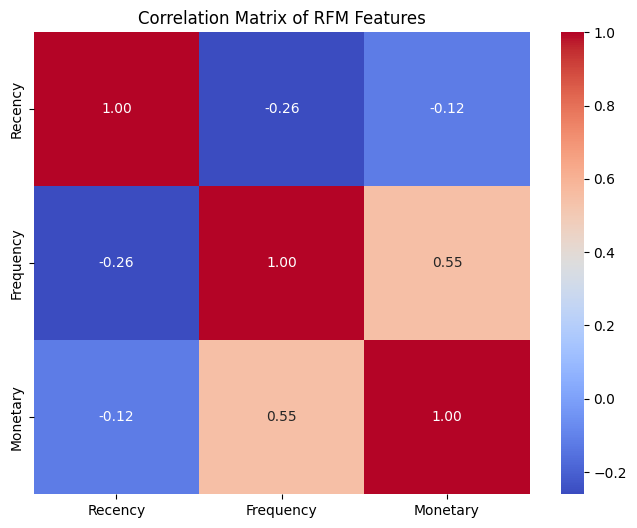

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of RFM Features')
plt.show()

###Visualisasi distribusi (histogram / boxplot)

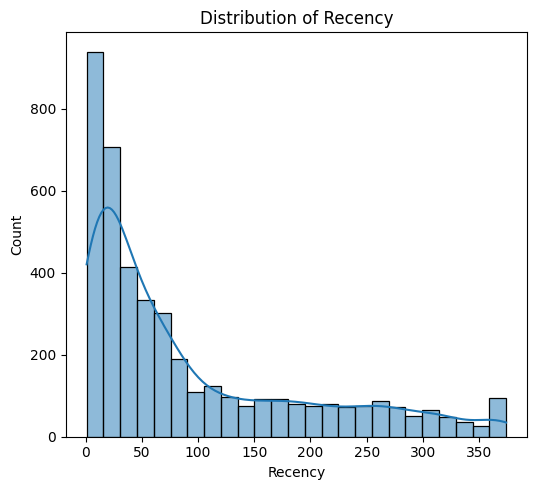

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Distribution of Recency')

plt.tight_layout()
plt.show()

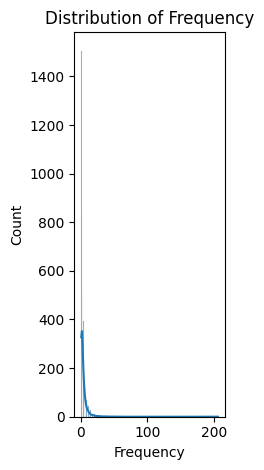

In [26]:
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Distribution of Frequency')

plt.tight_layout()
plt.show()

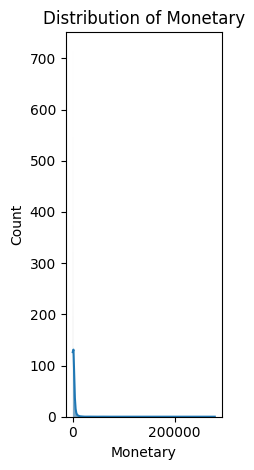

In [27]:
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], kde=True)
plt.title('Distribution of Monetary')

plt.tight_layout()
plt.show()

#Visualisasi Setelah RFM

In [28]:
revenue_per_country = df.groupby('Country')['TotalPrice'].sum().reset_index()
revenue_per_country = revenue_per_country.sort_values(by='TotalPrice', ascending=False)

print("Total revenue per country:")
display(revenue_per_country.head())
print(revenue_per_country.describe())

Total revenue per country:


,Country,TotalPrice
35,United Kingdom,7267337.23
23,Netherlands,283889.34
10,EIRE,262171.56
14,Germany,205569.89
13,France,184077.68


         TotalPrice
count  3.700000e+01
mean   2.369663e+05
std    1.190176e+06
min    1.459200e+02
25%    2.070590e+03
50%    9.120390e+03
75%    3.692734e+04
max    7.267337e+06


In [29]:
top_10_countries = revenue_per_country.head(10)

print("Top 10 countries by revenue:")
display(top_10_countries)

Top 10 countries by revenue:


,Country,TotalPrice
35,United Kingdom,7267337.23
23,Netherlands,283889.34
10,EIRE,262171.56
14,Germany,205569.89
13,France,184077.68
0,Australia,138171.31
30,Spain,55725.11
32,Switzerland,52441.95
19,Japan,37416.37
3,Belgium,36927.34


/tmp/ipython-input-2314158299.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='TotalPrice', data=top_10_countries, palette='viridis')


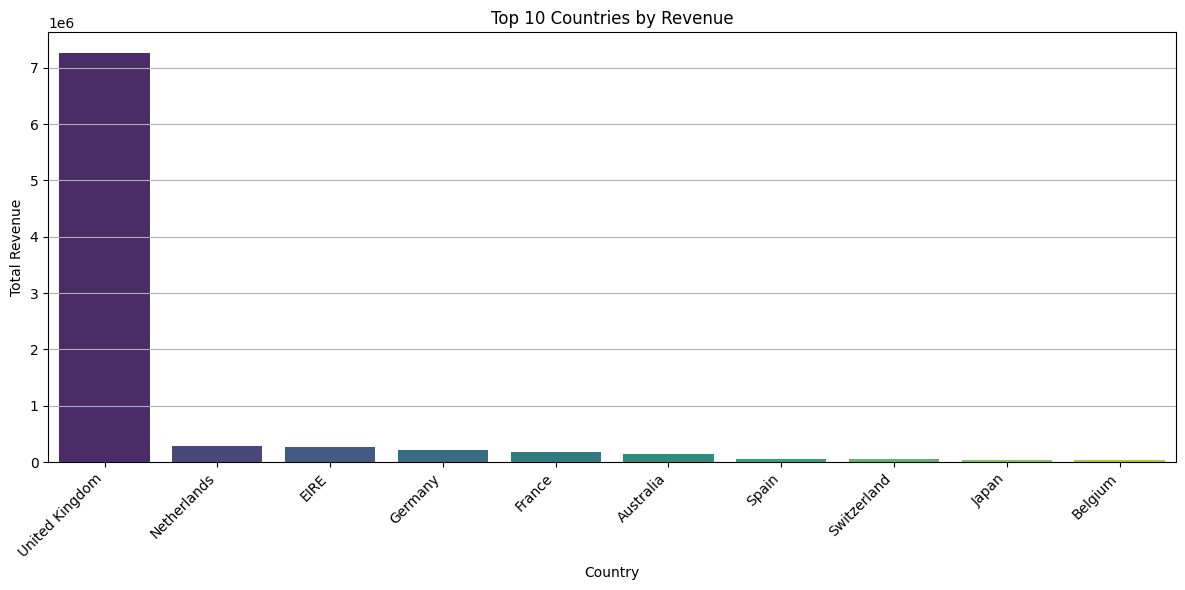

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='TotalPrice', data=top_10_countries, palette='viridis')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

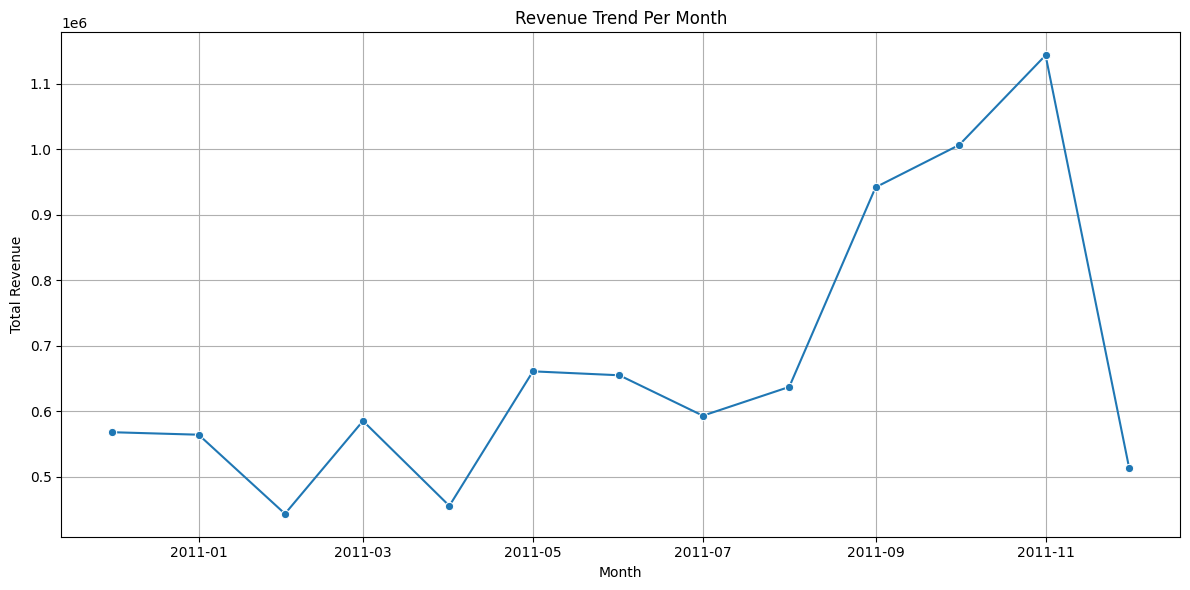

In [31]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
revenue_per_month = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
revenue_per_month['InvoiceMonth'] = revenue_per_month['InvoiceMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceMonth', y='TotalPrice', data=revenue_per_month, marker='o')
plt.title('Revenue Trend Per Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2452150014.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['DayOfWeek', 'HourOfDay']).size().unstack(fill_value=0)


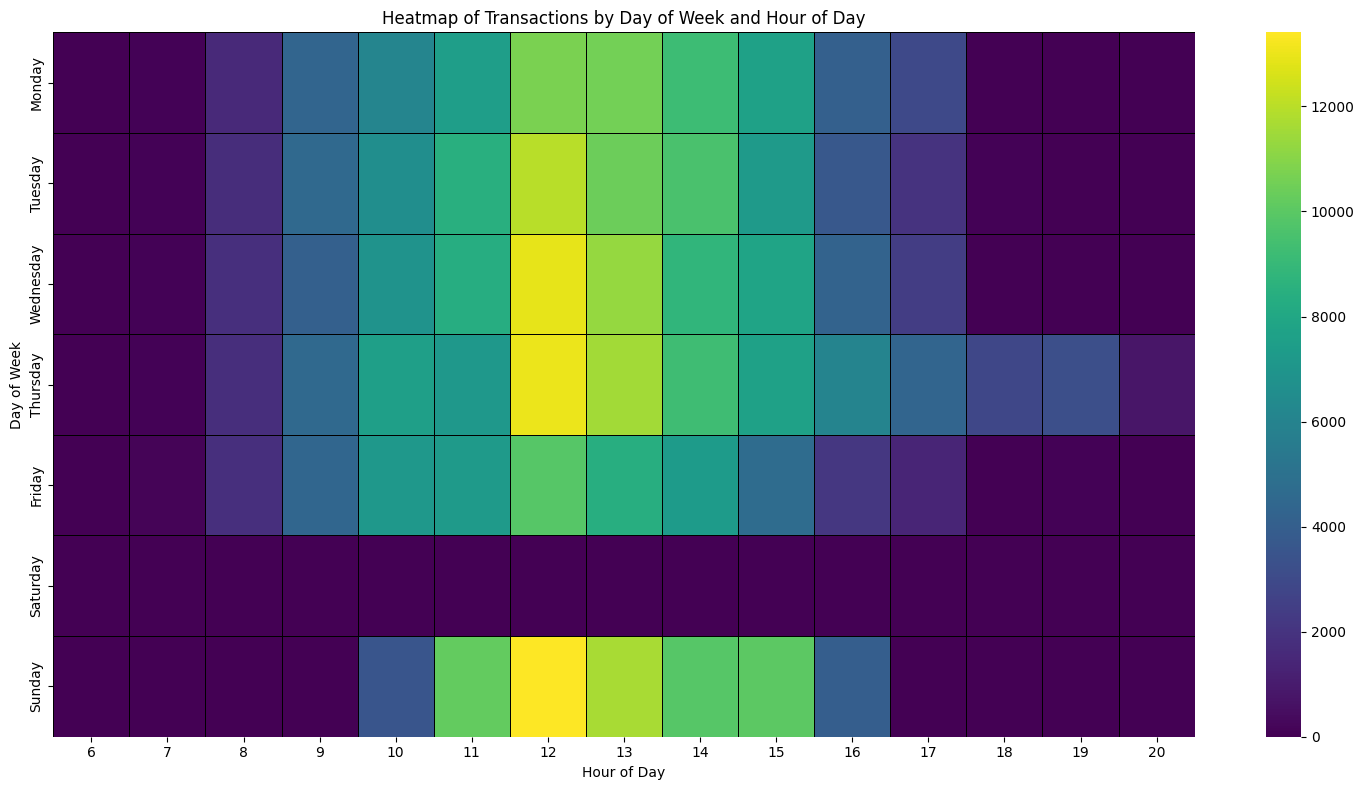

In [32]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Order days of the week correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_order, ordered=True)

# Create a pivot table for the heatmap
heatmap_data = df.groupby(['DayOfWeek', 'HourOfDay']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='viridis', fmt='d', linewidths=.5, linecolor='black')
plt.title('Heatmap of Transactions by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

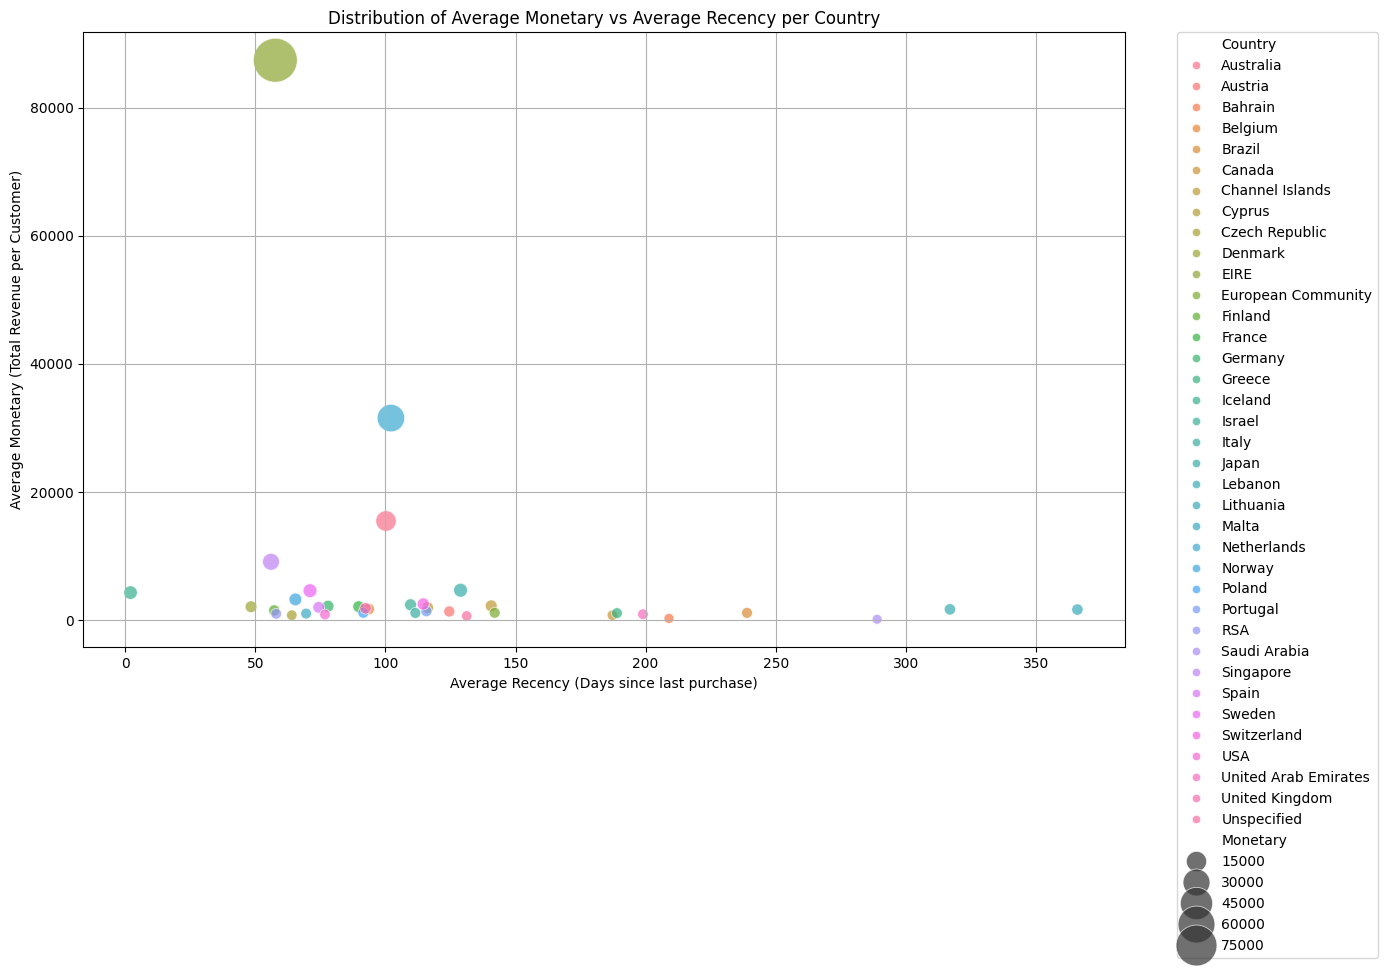

In [33]:
# Get unique CustomerID and Country mapping from the main DataFrame
customer_country_mapping = df[['CustomerID', 'Country']].drop_duplicates()

# Merge rfm_df with the customer_country_mapping to get country for each customer
rfm_with_country = pd.merge(rfm_df, customer_country_mapping, on='CustomerID', how='left')

# Calculate the average Recency and Monetary for each country
country_rfm_avg = rfm_with_country.groupby('Country')[['Recency', 'Monetary']].mean().reset_index()

# Create the scatter plot
plt.figure(figsize=(14, 9))
sns.scatterplot(data=country_rfm_avg, x='Recency', y='Monetary', hue='Country', size='Monetary', sizes=(50, 1000), alpha=0.7)
plt.title('Distribution of Average Monetary vs Average Recency per Country')
plt.xlabel('Average Recency (Days since last purchase)')
plt.ylabel('Average Monetary (Total Revenue per Customer)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

#Preprocessing untuk Clustering

###Standardisasi fitur (MinMaxScaler / StandardScaler)

In [34]:
rfm_scaled = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'])
rfm_scaled_df['CustomerID'] = rfm_df['CustomerID']

print("Scaled RFM features:")
display(rfm_scaled_df.head())
print(rfm_scaled_df.describe())

Scaled RFM features:


,Recency_Scaled,Frequency_Scaled,Monetary_Scaled,CustomerID
0,2.329399,-0.424750,8.424056,12346.0
1,-0.905391,0.360282,0.256378,12347.0
2,-0.176565,-0.032234,-0.065602,12348.0
3,-0.735664,-0.424750,-0.063325,12349.0
4,2.169656,-0.424750,-0.193691,12350.0


       Recency_Scaled  Frequency_Scaled  Monetary_Scaled    CustomerID
count    4.335000e+03      4.335000e+03     4.335000e+03   4335.000000
mean    -2.950350e-17     -4.261617e-17    -6.556334e-17  15298.780392
std      1.000115e+00      1.000115e+00     1.000115e+00   1722.075082
min     -9.153745e-01     -4.247504e-01    -2.266875e-01  12346.000000
25%     -7.456479e-01     -4.247504e-01    -1.924174e-01  13811.500000
50%     -4.161786e-01     -2.939117e-01    -1.518057e-01  15297.000000
75%      5.023420e-01      9.860439e-02    -4.383168e-02  16778.500000
max      2.808627e+00      2.639718e+01     3.105912e+01  18287.000000


###Cek outlier

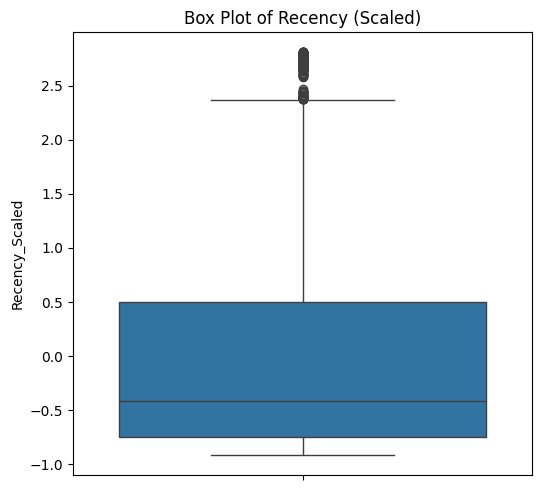

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm_scaled_df['Recency_Scaled'])
plt.title('Box Plot of Recency (Scaled)')

plt.tight_layout()
plt.show()

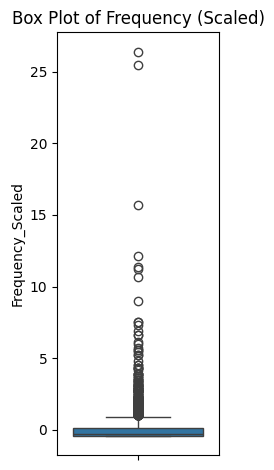

In [36]:
plt.subplot(1, 3, 2)
sns.boxplot(y=rfm_scaled_df['Frequency_Scaled'])
plt.title('Box Plot of Frequency (Scaled)')

plt.tight_layout()
plt.show()

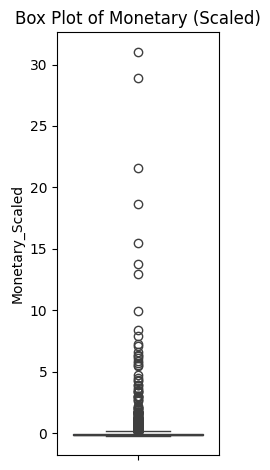

In [37]:
plt.subplot(1, 3, 3)
sns.boxplot(y=rfm_scaled_df['Monetary_Scaled'])
plt.title('Box Plot of Monetary (Scaled)')

plt.tight_layout()
plt.show()

###Addressing Outliers with Log Transformation

In [38]:
import numpy as np

# Apply log transformation (using log1p to handle potential zero values gracefully)
rfm_log_transformed = rfm_df[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

print("RFM features after log transformation:")
display(rfm_log_transformed.head())
print(rfm_log_transformed.describe())

RFM features after log transformation:


,Recency,Frequency,Monetary
0,5.789960,0.693147,11.253955
1,1.098612,2.079442,8.368925
2,4.330733,1.609438,7.271175
3,2.995732,0.693147,7.285198
4,5.739793,0.693147,5.688330


           Recency    Frequency     Monetary
count  4335.000000  4335.000000  4335.000000
mean      3.831813     1.341562     6.579864
std       1.340726     0.681867     1.257438
min       0.693147     0.693147     0.000000
25%       2.944439     0.693147     5.726082
50%       3.951244     1.098612     6.505948
75%       4.969813     1.791759     7.397853
max       5.926926     5.332719    12.539465


###Re-scaling Log-Transformed Features

In [39]:
scaler_log = StandardScaler()
rfm_scaled_log = scaler_log.fit_transform(rfm_log_transformed)

rfm_scaled_log_df = pd.DataFrame(rfm_scaled_log, columns=['Recency_Scaled_Log', 'Frequency_Scaled_Log', 'Monetary_Scaled_Log'])
rfm_scaled_log_df['CustomerID'] = rfm_df['CustomerID']

print("Scaled RFM features after log transformation:")
display(rfm_scaled_log_df.head())
print(rfm_scaled_log_df.describe())

Scaled RFM features after log transformation:


,Recency_Scaled_Log,Frequency_Scaled_Log,Monetary_Scaled_Log,CustomerID
0,1.460681,-0.951050,3.717582,12346.0
1,-2.038833,1.082271,1.422946,12347.0
2,0.372170,0.392902,0.549841,12348.0
3,-0.623675,-0.951050,0.560994,12349.0
4,1.423259,-0.951050,-0.709090,12350.0


       Recency_Scaled_Log  Frequency_Scaled_Log  Monetary_Scaled_Log  \
count        4.335000e+03          4.335000e+03         4.335000e+03   
mean        -3.278167e-18         -5.572884e-17         3.474857e-16   
std          1.000115e+00          1.000115e+00         1.000115e+00   
min         -2.341290e+00         -9.510504e-01        -5.233356e+00   
25%         -6.619371e-01         -9.510504e-01        -6.790636e-01   
50%          8.908963e-02         -3.563419e-01        -5.878954e-02   
75%          8.488923e-01          6.603189e-01         6.505946e-01   
max          1.562851e+00          5.853956e+00         4.740024e+00   

         CustomerID  
count   4335.000000  
mean   15298.780392  
std     1722.075082  
min    12346.000000  
25%    13811.500000  
50%    15297.000000  
75%    16778.500000  
max    18287.000000  


###Re-checking Outliers with Box Plots (Log-Transformed and Scaled)

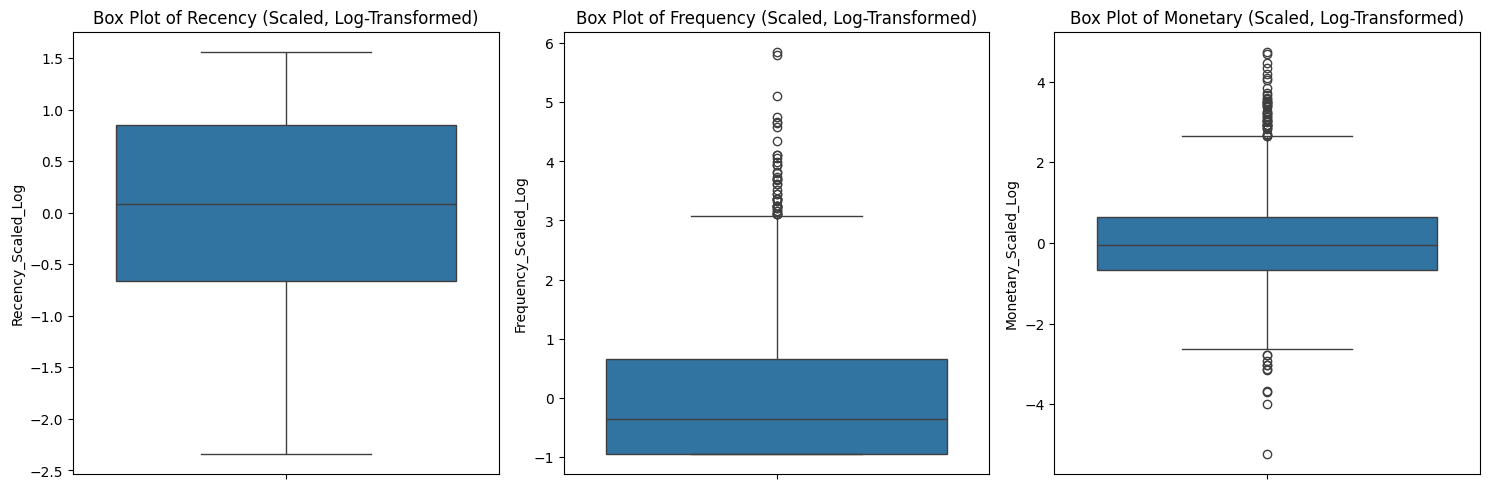

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm_scaled_log_df['Recency_Scaled_Log'])
plt.title('Box Plot of Recency (Scaled, Log-Transformed)')

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm_scaled_log_df['Frequency_Scaled_Log'])
plt.title('Box Plot of Frequency (Scaled, Log-Transformed)')

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm_scaled_log_df['Monetary_Scaled_Log'])
plt.title('Box Plot of Monetary (Scaled, Log-Transformed)')

plt.tight_layout()
plt.show()

#Menentukan Jumlah Cluster Optimal

###Calculate WCSS for different cluster numbers

In [41]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_log_df[['Recency_Scaled_Log', 'Frequency_Scaled_Log', 'Monetary_Scaled_Log']])
    wcss.append(kmeans.inertia_)

print("WCSS values for k from 1 to 10:")
print(wcss)

WCSS values for k from 1 to 10:
[13005.00000000004, 6486.4045689816285, 4872.991121140738, 3946.3443687572744, 3304.544885661178, 2863.9697516020046, 2561.556917196222, 2349.1282128872613, 2169.574702914888, 2016.0940421712714]


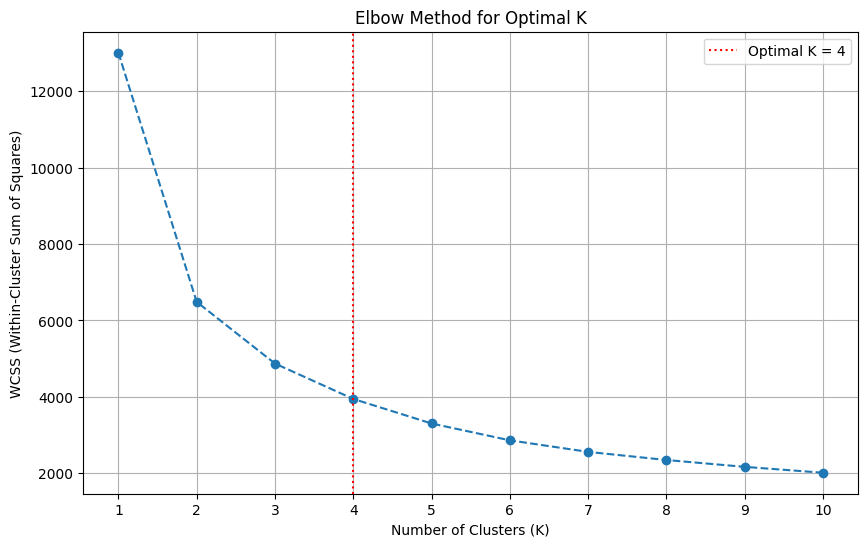

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)

# Adding a label for the suggested optimal k
optimal_k = 4 # Based on visual inspection of the elbow curve
plt.axvline(x=optimal_k, color='r', linestyle=':', label=f'Optimal K = {optimal_k}')
plt.legend()
plt.show()

#Clustering (K-Means)

###Train K-Means Model


In [43]:
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_model.fit(rfm_scaled_log_df[['Recency_Scaled_Log', 'Frequency_Scaled_Log', 'Monetary_Scaled_Log']])

print(f"K-Means model trained with {optimal_k} clusters.")

K-Means model trained with 4 clusters.


In [44]:
cluster_labels = kmeans_model.predict(rfm_scaled_log_df[['Recency_Scaled_Log', 'Frequency_Scaled_Log', 'Monetary_Scaled_Log']])
rfm_df['Cluster'] = cluster_labels
rfm_scaled_log_df['Cluster'] = cluster_labels

print("RFM DataFrame with cluster assignments:")
display(rfm_df.head())

RFM DataFrame with cluster assignments:


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,0
1,12347.0,2,7,4310.00,3
2,12348.0,75,4,1437.24,0
3,12349.0,19,1,1457.55,2
4,12350.0,310,1,294.40,1


###Evaluate Cluster Quality


In [45]:
X = rfm_scaled_log_df[['Recency_Scaled_Log', 'Frequency_Scaled_Log', 'Monetary_Scaled_Log']]
labels = rfm_scaled_log_df['Cluster']

silhouette_avg = silhouette_score(X, labels)

print(f"The Silhouette Score for the clustering is: {silhouette_avg:.4f}")

The Silhouette Score for the clustering is: 0.3376


#Business Interpretation: Nama Segmen

In [46]:
cluster_profile = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
display(cluster_profile)

,Cluster,Recency,Frequency,Monetary
0,0,67.111775,4.186007,1818.856886
1,1,182.725610,1.330488,352.529317
2,2,18.462455,2.112038,538.407855
3,3,11.657895,13.959064,8196.169751


In [47]:
# Calculate mean RFM values for each cluster to dynamically assign names
raw_cluster_profile = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Initialize cluster_names dictionary
cluster_names = {}

# Identify 'Big Spenders' (Champions): Lowest Recency, Highest Frequency, Highest Monetary
sorted_for_champions = raw_cluster_profile.sort_values(by=['Recency', 'Frequency', 'Monetary'], ascending=[True, False, False])
champions_cluster_id = sorted_for_champions.iloc[0]['Cluster']
cluster_names[champions_cluster_id] = 'Big Spenders'

# Identify 'New Customers': Highest Recency, Lowest Frequency, Lowest Monetary
# Note: Given the characteristics, this cluster might also be interpreted as 'Lapsed' or 'Lost Customers'.
# Sticking to 'New Customers' as per the original user's dictionary for consistency unless otherwise specified.
sorted_for_new_lapsed = raw_cluster_profile.sort_values(by=['Recency', 'Frequency', 'Monetary'], ascending=[False, True, True])
new_lapsed_cluster_id = sorted_for_new_lapsed.iloc[0]['Cluster']
cluster_names[new_lapsed_cluster_id] = 'New Customers'

# Identify the remaining two clusters: 'Loyal Customers' and 'At Risk Customers'
remaining_clusters = [c for c in raw_cluster_profile['Cluster'] if c not in cluster_names]

# Sort the remaining by Recency (lower Recency is Loyal, higher Recency is At Risk)
remaining_cluster_data = raw_cluster_profile[raw_cluster_profile['Cluster'].isin(remaining_clusters)].sort_values(by='Recency', ascending=True)

loyal_cluster_id = remaining_cluster_data.iloc[0]['Cluster']
cluster_names[loyal_cluster_id] = 'Loyal Customers'

at_risk_cluster_id = remaining_cluster_data.iloc[1]['Cluster']
cluster_names[at_risk_cluster_id] = 'At Risk Customers'


rfm_df['Cluster_Name'] = rfm_df['Cluster'].map(cluster_names)

print("Cluster profiles with assigned persona names:")
display(rfm_df.groupby('Cluster_Name')[['Recency', 'Frequency', 'Monetary']].mean().sort_values(by='Recency', ascending=True))

print("RFM DataFrame with Cluster and Persona Names:")
display(rfm_df.head())

Cluster profiles with assigned persona names:


,Recency,Frequency,Monetary
Cluster_Name,,,
Big Spenders,11.657895,13.959064,8196.169751
Loyal Customers,18.462455,2.112038,538.407855
At Risk Customers,67.111775,4.186007,1818.856886
New Customers,182.725610,1.330488,352.529317


RFM DataFrame with Cluster and Persona Names:


,CustomerID,Recency,Frequency,Monetary,Cluster,Cluster_Name
0,12346.0,326,1,77183.60,0,At Risk Customers
1,12347.0,2,7,4310.00,3,Big Spenders
2,12348.0,75,4,1437.24,0,At Risk Customers
3,12349.0,19,1,1457.55,2,Loyal Customers
4,12350.0,310,1,294.40,1,New Customers


In [54]:
print("Average RFM values per customer segment:")
display(rfm_df.groupby('Cluster_Name')[['Recency', 'Frequency', 'Monetary']].mean().sort_values(by='Recency', ascending=True))

print("\nNumber of customers in each segment:")
segment_counts = rfm_df['Cluster_Name'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']
segment_counts['Percentage'] = (segment_counts['Count'] / len(rfm_df)) * 100
display(segment_counts)

Average RFM values per customer segment:


,Recency,Frequency,Monetary
Cluster_Name,,,
Big Spenders,11.657895,13.959064,8196.169751
Loyal Customers,18.462455,2.112038,538.407855
At Risk Customers,67.111775,4.186007,1818.856886
New Customers,182.725610,1.330488,352.529317



Number of customers in each segment:


,Segment,Count,Percentage
0,New Customers,1640,37.831603
1,At Risk Customers,1172,27.035755
2,Loyal Customers,839,19.354095
3,Big Spenders,684,15.778547


#Visualisasi Segmentasi

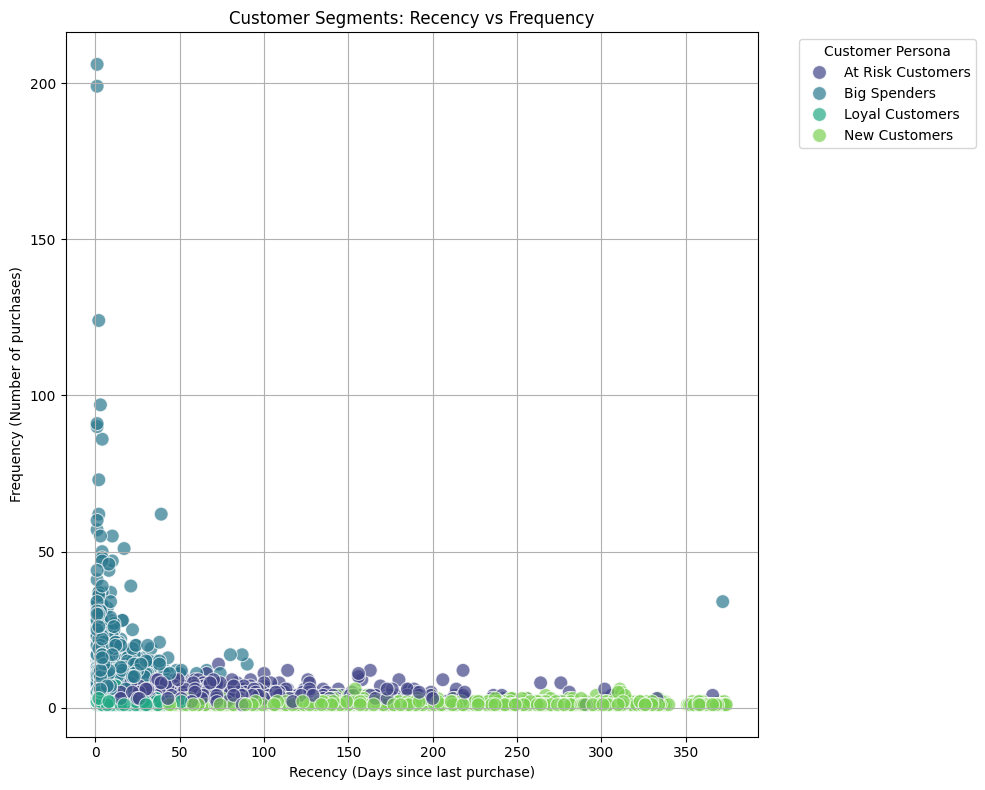

In [48]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster_Name', palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments: Recency vs Frequency')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Frequency (Number of purchases)')
plt.legend(title='Customer Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2839446931.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='Cluster_Name', palette='viridis', order=rfm_df['Cluster_Name'].value_counts().index)


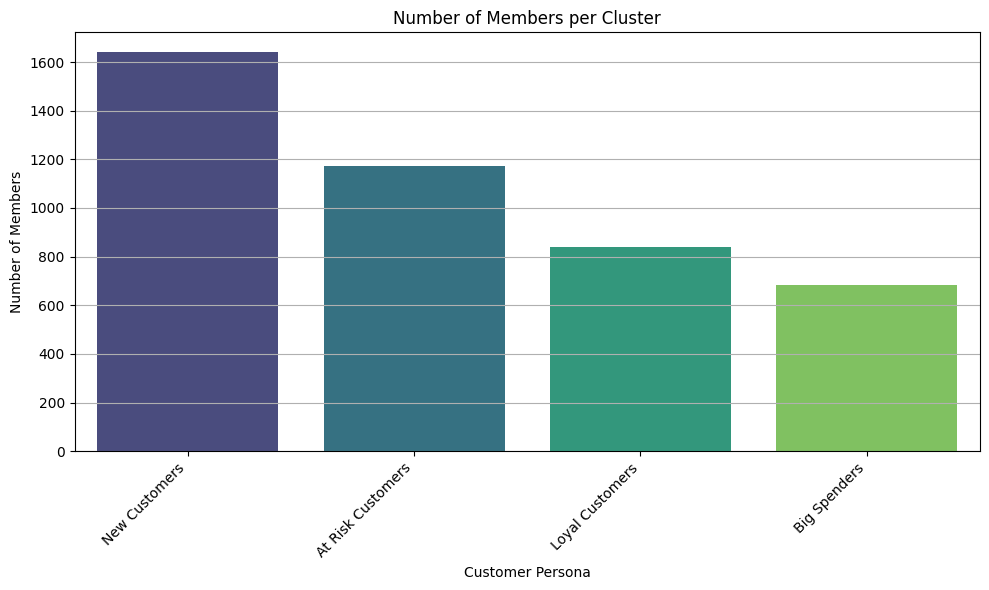

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_df, x='Cluster_Name', palette='viridis', order=rfm_df['Cluster_Name'].value_counts().index)
plt.title('Number of Members per Cluster')
plt.xlabel('Customer Persona')
plt.ylabel('Number of Members')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

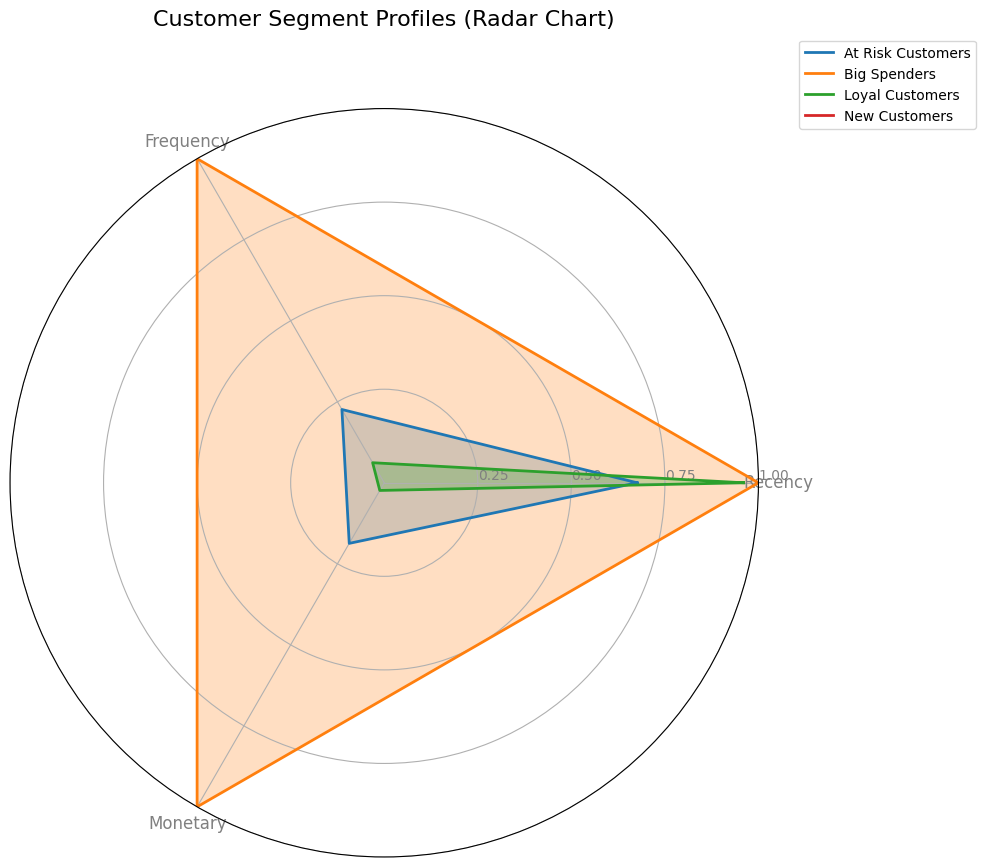

In [50]:
from math import pi

# Get cluster profiles (average RFM values)
cluster_profile = rfm_df.groupby('Cluster_Name')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Normalize RFM values for radar chart (scaling to 0-1 or similar range)
# A simple min-max scaling for each feature independently
cluster_profile_normalized = cluster_profile.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    min_val = cluster_profile_normalized[col].min()
    max_val = cluster_profile_normalized[col].max()
    # Recency is better when lower, so invert its scale
    if col == 'Recency':
        cluster_profile_normalized[col] = (max_val - cluster_profile_normalized[col]) / (max_val - min_val)
    else:
        cluster_profile_normalized[col] = (cluster_profile_normalized[col] - min_val) / (max_val - min_val)

# Number of variables
categories = ['Recency', 'Frequency', 'Monetary']
N = len(categories)

# What angle for each category?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot each cluster
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Helper to reverse 'Recency' interpretation for plotting
def get_values_for_plot(row, categories):
    values = row[categories].tolist()
    values += values[:1]
    return values

for i, row in cluster_profile_normalized.iterrows():
    values = get_values_for_plot(row, categories)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Cluster_Name'])
    ax.fill(angles, values, alpha=0.25)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1], ["0.25", "0.50", "0.75", "1.00"], color="grey", size=10)
plt.ylim(0, 1)

plt.title('Customer Segment Profiles (Radar Chart)', size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

#Rekomendasi Strategi Marketing

### Rekomendasi Strategi Pemasaran Berdasarkan Segmen Pelanggan

Berdasarkan karakteristik Recency, Frequency, dan Monetary (RFM) dari tiap segmen pelanggan, berikut adalah rekomendasi strategi pemasaran yang dapat diimplementasikan:

*   **Big Spenders (Cluster 1)**
    *   **Karakteristik:** Pelanggan yang paling sering berbelanja, menghabiskan uang paling banyak, dan paling baru melakukan pembelian.
    *   **Strategi:**
        *   **VIP Program:** Tawarkan program loyalitas eksklusif dengan reward yang menarik, akses awal ke produk baru, atau diskon khusus.
        *   **Personalized Recommendations:** Berikan rekomendasi produk yang sangat personal berdasarkan riwayat pembelian mereka yang sering dan bernilai tinggi.
        *   **Premium Customer Service:** Sediakan layanan pelanggan prioritas untuk memastikan pengalaman belanja yang luar biasa.

*   **Loyal Customers (Cluster 2)**
    *   **Karakteristik:** Pelanggan yang cukup sering berbelanja dan baru-baru ini melakukan pembelian, namun dengan nilai transaksi yang moderat.
    *   **Strategi:**
        *   **Retention Programs:** Fokus pada mempertahankan loyalitas mereka melalui poin reward, diskon berkala, atau penawaran khusus untuk pembelian berulang.
        *   **Engagement Campaigns:** Kirimkan newsletter atau konten menarik yang relevan dengan minat mereka untuk menjaga hubungan.
        *   **Upselling/Cross-selling:** Promosikan produk pelengkap atau versi premium dari produk yang sering mereka beli.

*   **At Risk Customers (Cluster 0)**
    *   **Karakteristik:** Pelanggan yang memiliki frekuensi dan nilai transaksi moderat, tetapi sudah cukup lama tidak berbelanja (recency tinggi).
    *   **Strategi:**
        *   **Re-engagement Campaigns:** Kirimkan penawaran diskon khusus atau insentif untuk mendorong pembelian kembali.
        *   **Win-back Offers:** Tawarkan produk gratis atau bonus untuk pembelian berikutnya.
        *   **Feedback Survey:** Ajak mereka mengisi survei untuk mengetahui alasan mereka tidak aktif dan bagaimana cara memperbaikinya.

*   **New Customers (Cluster 3)**
    *   **Karakteristik:** Pelanggan yang baru melakukan satu atau dua pembelian dan mungkin dengan nilai transaksi yang relatif kecil, serta sudah cukup lama tidak berbelanja.
    *   **Strategi:**
        *   **Welcome Offers:** Berikan diskon khusus untuk pembelian pertama atau kedua untuk mendorong eksplorasi lebih lanjut.
        *   **Onboarding Campaign:** Kirimkan panduan penggunaan produk, tips & trik, atau informasi relevan lainnya untuk membantu mereka mendapatkan nilai dari pembelian awal mereka.
        *   **Building Relationship:** Ajak mereka bergabung dengan komunitas atau program loyalitas dasar untuk mulai membangun hubungan jangka panjang.

In [51]:
# Export rfm_df to CSV
rfm_df.to_csv('rfm_df.csv', index=False)
print("rfm_df.csv exported successfully.")

# Export revenue_per_month to CSV
revenue_per_month.to_csv('revenue_month.csv', index=False)
print("revenue_month.csv exported successfully.")

# Export heatmap_data to CSV
# For heatmap_data, if the index contains meaningful labels (like 'DayOfWeek'), keep it.
heatmap_data.to_csv('heatmap_data.csv', index=True)
print("heatmap_data.csv exported successfully.")

# Export top_10_countries to CSV
top_10_countries.to_csv('top10_country.csv', index=False)
print("top10_country.csv exported successfully.")

# Export cluster_profile to CSV
cluster_profile.to_csv('cluster_profile.csv', index=False)
print("cluster_profile.csv exported successfully.")

rfm_df.csv exported successfully.
revenue_month.csv exported successfully.
heatmap_data.csv exported successfully.
top10_country.csv exported successfully.
cluster_profile.csv exported successfully.


In [52]:
import joblib

# Define the filename for the model
model_filename = 'kmeans_clustering_model.joblib'

# Save the trained K-Means model
joblib.dump(kmeans_model, model_filename)
print(f"K-Means model saved to {model_filename}")

# To 'import' (load) the model back into a new variable:
loaded_kmeans_model = joblib.load(model_filename)
print(f"K-Means model loaded from {model_filename}")

# You can now use 'loaded_kmeans_model' just like 'kmeans_model'
# For example, to predict clusters for new data:
# new_data_point = rfm_scaled_log_df[['Recency_Scaled_Log', 'Frequency_Scaled_Log', 'Monetary_Scaled_Log']].iloc[0].values.reshape(1, -1)
# predicted_cluster = loaded_kmeans_model.predict(new_data_point)
# print(f"Predicted cluster for a sample data point: {predicted_cluster[0]}")

K-Means model saved to kmeans_clustering_model.joblib
K-Means model loaded from kmeans_clustering_model.joblib
